**libs**

In [ ]:
import cv2
import os
import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime as dt
import tensorflow as tf

from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Input
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.preprocessing import normalize
from random import sample, randint


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# How to map action to weights

* There will be 32 output neuron at output layer

* Model should be a multi classification model which means output layer activation function has to be softmax.

* but activation function of dqn shoud be lienar because it tries to find q values of action -state pairs

* outputs 0-31

* toget weights first convert tem to binary format list like 31 = [1, 1, 1, 1, 1]

* All of these one and zeros stands for a instrument and indicates if whether to buy or not

* We will buy these instruments relative to their sharpe ratios.


# Params

In [ ]:
#Environment params
TIMESTEP = 30
FEATSNUM = 6
TRAIN_TEST = "2019-05-03"
#eur xau sp nasdaq usd
INSTRUMENTNUM = 5
INSTRUMENTS = ("EURUSD=X", "GC=F", "^GSPC", "^IXIC", "USD")

#model
ACTIONS = 2 ** INSTRUMENTNUM - 1 #cünkü alt kümelerden bos 
ACTIVATION = "relu"
INPUTDIMS = TIMESTEP * FEATSNUM * (INSTRUMENTNUM - 1)

MIN_EPSILON = 0.05
#Initialize replay memory capacity.
MEMORY_SIZE_LIMIT = 1000
DISCOUNT = 0.99
MINIBATCH_SIZE = 32
##################
#değeri 1 idi TARGET_UPDATE in
TARGET_UPDATE = 100
EPISODES = 20
MAX_STEP_LIMIT = 500

In [ ]:
INPUTDIMS

720

# Utils

In [ ]:
def normalize(v):
    norm = tf.math.reduce_sum(v)
    #print("norm: ",norm)
    return v / norm

def converter(x : int):
    x += 1
    res = list()
    while x >0:
        res.insert(0,x % 2)
        x = x // 2
    
    zeros = 5 - len(res) 
    
    res = [0 for i in range(zeros)] + res
    
    return res

In [ ]:
class EpisodeData:

    def __init__(self):
        self.rewards = list()
        self.totalOfGoods = list()
        self.weights = list()
        self.baskets = list()

    def add(self, reward, totalOfGood):
        self.rewards.append(reward)
        self.totalOfGoods.append(totalOfGood)

    def plot(self):
        plt.plot(self.totalOfGoods)
        plt.show()

# Environment

In [ ]:
class Market:
    def __init__(self, totalOfGoods : float = 1000., howToReorganize : bool = False ,startDateOfMarket : dt.datetime =  dt.datetime(2004,1,1), endDateOfMarket : dt.datetime =  dt.datetime(2018,1,1)):
        #hold copy of totalOfGoods for reseting environment
        self._startGoodsValue = totalOfGoods
        self.bigData = list()
        self._initializationOfVariables()
        self._lastDate = 0
        self.howToReorganize = howToReorganize

        self.startDateOfMarket = startDateOfMarket
        self.endDateOfMarket = endDateOfMarket
        

    def _retrieveData(self) -> None:
        """
        Retrieve instuments data from market

        Returns None
        """
        for instrument in INSTRUMENTS:
            if (instrument == "USD"):
                continue
            df = web.DataReader(instrument, "yahoo", self.startDateOfMarket, self.endDateOfMarket)
            self.bigData.append(df)

        if (self.howToReorganize):
            self.reorganizeBigDataGetAll()
        else:
            self.reorganizeBigData()
    
    def reorganizeBigData(self):
        """
        burada hepsini euro dolara göre aldım
        """

        self.bigData[0] = self.bigData[0].shift(1, freq = "D")
        usaIndex = set(self.bigData[0].index)
        goldIndex = set(self.bigData[1].index)
        londonIndex = set(self.bigData[1].index)

        reIndex = usaIndex.union(goldIndex)
        self.bigData[1] = self.bigData[1].reindex(list(reIndex)).sort_index().ffill().bfill().reindex(self.bigData[0].index).sort_index().ffill().bfill()

        reIndex = usaIndex.union(londonIndex)
        self.bigData[2] = self.bigData[2].reindex(list(reIndex)).sort_index().ffill().bfill().reindex(self.bigData[0].index).sort_index().ffill().bfill()

        self.bigData[3] = self.bigData[3].reindex(list(reIndex)).sort_index().ffill().bfill().reindex(self.bigData[0].index).sort_index().ffill().bfill()

    def reorganizeBigDataGetAll(self):
        """
        nu metodla hepsinin günlerini esitledim
        """
        
        reIndex = set ()
        for df in self.bigData:
            temp = set (df.index)
            reIndex = reIndex.union(temp)
        
        for i in range(len(self.bigData)):
            self.bigData[i] = self.bigData[i].reindex(reIndex).ffill()
            self.bigData[i].bfill(inplace = True)
            self.bigData[i].sort_index(inplace=True)

    def _initializationOfVariables(self) -> None:
        """
        Every time user call reset method _initializationOfVariables method invoked automatically to reset necessary variables
        to their initial values

        Returns None
        """
        
        self.totalOfGoods = self._startGoodsValue
        self.analizeStartDate = 0 
        self.timeInterval = TIMESTEP
        self.currentDate = TIMESTEP

        # basket is a list that holds how much of instruments is in our basket by its unit 
        self.basket = np.zeros(INSTRUMENTNUM)
        self.weights = np.zeros(INSTRUMENTNUM)

        self.weights[INSTRUMENTNUM-1] = 1
        self.basket[INSTRUMENTNUM-1] = self.totalOfGoods
        
    
    def start(self) -> np.array:
        """
        Start environment by retreiving necessary market data.

        Returns state
        """
        self._retrieveData()
        #set last date
        self._lastDate = len(self.bigData[0])
        
        state = self._getCurrentState()
        return state


    def reset(self):
        self._initializationOfVariables()
        state =  self._getCurrentState()
        return state



    def _getCurrentState(self) -> np.array:
        """
        Calculate current state respective to self.currentDate

        Returns current State of market as a np.array
        """
        state = list ()
        for instrumentDF in self.bigData:
            df = instrumentDF.iloc[self.analizeStartDate:self.currentDate,:].copy()
            
            #normalize data and rearrange headers
            self.preprocessRawData(df)
            state.append(df)
        
        #its Shape is (INSTRUMENTNUM - 1,TIMESTEP,FEATSNUM,1) 
        return np.array(state).reshape((-1,TIMESTEP,FEATSNUM,1)).astype('float32')

    def preprocessRawData(self, df) -> None:
        # High       Low      Open     Close  Volume  Adj Close
        df["H"] = df.loc[:, "High"] / df.iloc[0, 0]
        df["L"] = df.loc[:, "Low"] / df.iloc[0, 1]
        df["H-Step"] = (df.loc[:, "High"] - df.loc[:, "Low"]) / df.loc[:, "Low"]
        #df["C"] = df.loc[:, "Close"] / df.iloc[0, "Close"] 
        df["O"] = df.loc[:, "Open"] / df.iloc[0, 2]
        df["C-Step"] = (df.loc[:, "Close"] - df.loc[:, "Open"] ) / df.loc[:, "Open"]
        df.loc[:, "Adj Close"] = df.loc[:, "Adj Close"] / df.iloc[0, 5]
        df.drop(["Volume", "High", "Close", "Low", "Open"],axis=1 , inplace= True)

    def sharpeRatioPaper(self, returns : np.array) -> float:
        """
        calculate sharpe ratio of given array

        returns: close prices of a instruments 

        return sharpe ratio 
        """
        return returns.mean() / returns.std()


    def calculateWeightsFromAction(self, action : np.array) -> np.array:
        """
        calculates weights of instrumnets which are going to be bought 
        actually sharperatio of instruments will be used as their weights directly

        """
        result = np.array(action)
        for i in range(len(action)-1):
            if (action[i] == 0):
                continue
            adjCloseArray = np.array(self.bigData[i].iloc[self.analizeStartDate:self.currentDate, 5])
            weight = self.sharpeRatioPaper(adjCloseArray)
            result[i] =  weight
        
        return result


    def _buyAllInstruments(self):
        
        loss : float = 0
        #print("weights: ", self.weights)
        for index in range(INSTRUMENTNUM-1):
            closePrice = self.bigData[index].iloc[self.currentDate-1 , 3]
            unitLoss = self.totalOfGoods * self.weights[index]
            #print("unitLoss: ", unitLoss)
            loss += unitLoss
            self.basket[index] =  unitLoss / closePrice if ( unitLoss != 0 ) else 0
        
        #for dolar
        index += 1
        self.basket[index] = self.totalOfGoods * self.weights[index]

        return loss

    def _sellAllInstruments(self) -> float:
        """
        this method sells all instruments and adds profit to "totalOfGoods"
        """
        profit = 0
        #because last one is usd
        for index in range(INSTRUMENTNUM-1):
            closePrice = self.bigData[index].iloc[self.currentDate, 3]
            unitProfit = closePrice * self.basket[index]
            profit += unitProfit
            self.basket[index] = 0. 
        
        index += 1
        self.totalOfGoods = profit + self.basket[index] if (profit + self.basket[index] != 0) else self.totalOfGoods
        return profit

    
    def incrementDay(self):
        """
        This method increment currentDate and _startDate and returns a bool value
        if new currentDate value is either more than or equal to _last day in our data then it returns False
        else it returns True
        """
        self.currentDate += 1
        self.analizeStartDate =  int(self.currentDate - self.timeInterval)

        done = self.currentDate >= self._lastDate - 1
        return done


    def step(self, action : int, logFile, normalizedReward : float = False):
        """
        Buy instruments at last days close
        sell them all at close
        increment day

        weights: is an np.array that holds how to disturbue total money to insturuments which is also action
        normalizedReward: if it is true than returns normalized profit else normal profit default False 

        Returns (nextState, reward, done)
        """
        logFile.write(f"action: {action}\n")
        weights = converter(action)
        logFile.write(f"converted weights: {weights}\n")
        weights = self.calculateWeightsFromAction(weights)
        logFile.write(f"calculateWeightsFromAction: {weights}\n")
        self.weights = np.array(normalize(weights))
        logFile.write(f"normalized weights: {self.weights}\n")

        oldTotalOfGoods = self.totalOfGoods
        loss = self._buyAllInstruments()
        self.basketCopy = self.basket.copy()
        profit = self._sellAllInstruments()


        reward = (profit - loss) * 1000 / oldTotalOfGoods if normalizedReward else profit - loss

        logFile.write(f"current day: {self.currentDate}\n")
        logFile.write(f"last day: {self._lastDate}\n")
        logFile.write(f"weights: {self.weights}\n")
        logFile.write(f"profit: {profit}\n")
        logFile.write(f"loss: {loss}\n")
        logFile.write(f"profit-loss: {profit - loss}\n")
        logFile.write(f"reward: {reward}\n")
        logFile.write(f"old totalOfGoods: {oldTotalOfGoods}\n")
        logFile.write(f"new totalOfGoods: {self.totalOfGoods}\n")

        done = self.incrementDay()

        logFile.write(f"done: {done}\n")
        nextState = self._getCurrentState()

        return (nextState, reward, done)

# DQN

In [ ]:
class DQN:

    def __init__(self):

        #Initialize the policy network with random weights.
        self.policy = self.build_model()
        self.target = self.build_model()
        #Clone the policy network, and call it the target network.

        self.target.set_weights(self.policy.get_weights())
        self.epsilon = 1
        self.replay_memory = []
        self.clone_models_counter = 0

    def build_model(self):
        model = Sequential()

        model.add(Input(shape=(INPUTDIMS,), name= "giris"))
        model.add(Dense(512, activation = ACTIVATION))
        model.add(Dense(512 * 2, activation = ACTIVATION))
        model.add(Dense(512 * 2, activation = ACTIVATION))
        model.add(Dense(512, activation = ACTIVATION))

        model.add(Dense(ACTIONS, activation='linear'))  # ACTION_SPACE_SIZE = how many choices (9)

        model.compile(loss="mse", optimizer=Adam(lr=0.001), metrics=['accuracy'])
        return model

    def append_to_memory(self, observation):
        
        if(len(self.memory) < MEMORY_LIMIT):
            self.memory.append(observation)
            
        else:
            self.memory.pop(0)
            self.memory.append(observation)

    def epsilon_decay(self):
        if(self.epsilon > MIN_EPSILON):
            self.epsilon *= 0.9

    def append_to_replay_memory(self, experience):
        self.replay_memory.append(experience)
        if(len(self.replay_memory) > MEMORY_SIZE_LIMIT):
            self.replay_memory.pop(0)

    # get q values for current state from self.model
    def get_q_values(self, state):
        return self.policy.predict(state)
    
    def get_action_from_policy(self, state):
        return self.policy.predict(state)
    
    def _get_action_from_target(self, state):
        return self.target.predict(state)

    # Trains main network every step during episode
    def train(self, terminal_step, episode, step):

        if(len(self.replay_memory) < MINIBATCH_SIZE):
            return
        #Sample random batch from replay memory.
        minibatch = sample(self.replay_memory, MINIBATCH_SIZE)

        #Preprocess states from batch.
        #experience = (current_state, action, reward, done, next_state)
        current_states = np.array([batch[0] for batch in minibatch])
        next_states = np.array([batch[4] for batch in minibatch])

        #Pass batch of preprocessed states to policy network.
        #   Requires a pass to the target network for the next state
        current_q_values = self.get_action_from_policy(current_states)
        next_q_values = self._get_action_from_target(next_states)

        #X and y will be used to keep states and new q values for fitting policy model
        X = list()
        y = list()

        for index, (current_state, action, reward, done, new_current_state) in enumerate(minibatch):

            #Bellman Equation
            if not done:
                max_next_q = np.max(next_q_values[index])
                new_q = reward + DISCOUNT * max_next_q
            else:
                new_q = reward

            # Update Q value for given state
            current_qs = current_q_values[index]
            current_qs[action] = new_q

            #i appended current_states[index] instead of current_state because it was preprocessed aldready (line 144)
            X.append(current_states[index])
            y.append(current_qs)

        #Gradient descent updates weights in the policy network to minimize loss.
        self.policy.fit(np.array(X), np.array(y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=False)
        
        ###################################################
        ##her 500 adımda bir terminal step True olarak geliyor 
        ###################################################

        #After ceratin time steps, weights in the target network are updated to the weights in the policy network
        if(step % TARGET_UPDATE ==0 or terminal_step):
            self.target.set_weights(self.policy.get_weights())
            print("*"*25)
            self.clone_models_counter = 0

    # Queries main network for Q values given current observation space (environment state)
    def get_qs(self, state):
        return self.policy.predict(np.array(state).reshape(-1, *state.shape))[0]




In [ ]:
agent = DQN()
env = Market( startDateOfMarket=dt.datetime(2004,1,1), endDateOfMarket= dt.datetime(2018,1,1))

#for testing
testEnv = Market(startDateOfMarket=dt.datetime(2018,1,1), endDateOfMarket=dt.datetime(2021,1,1))
groundTruhth = Market(startDateOfMarket=dt.datetime(2018,1,1), endDateOfMarket=dt.datetime(2021,1,1))

testEnv.start()
groundTruhth.start()
print("")

In [ ]:
def test(agent : DQN):
    current_state = testEnv.reset().flatten()
    groundTruhth.reset()
    episodeLog = EpisodeData()
    episodeLogGT = EpisodeData()

    savePath = "/content/drive/My Drive/testLogs/"
    done = False
    step = 0

    if(not os.path.exists(f"{savePath}")):
        os.mkdir(f"{savePath}")
        os.mkdir(f"{savePath}plots/")

    Log_file_name = f"testLog_{dt.datetime.now()}"
    Log_file_name_gt = f"{savePath}groundTruthLog_{dt.datetime.now()}.txt"
    logFile = open(savePath+Log_file_name+".txt", "w")
    groundTruthLogFile = open(f"{savePath}groundTruthLog_{dt.datetime.now()}.txt", "w")
    
    while (not done):
        logFile.write("-"*5 + f"Turn: {step} "+ "-"*5 + "\n")
        groundTruthLogFile.write("-"*5 + f"Turn: {step} "+ "-"*5 + "\n")

        next_state, reward, done =  groundTruhth.step(30, groundTruthLogFile, normalizedReward=True)

        episodeLogGT.add(reward, groundTruhth.totalOfGoods)

        action = np.argmax(agent.get_action_from_policy(current_state.reshape(1,INPUTDIMS)))

        action = int(action)
        next_state, reward, done =  testEnv.step(action, logFile, normalizedReward=True)

        episodeLog.add(reward, testEnv.totalOfGoods)

        current_state = next_state
        step += 1
    
    logFile.close()
    groundTruthLogFile.close()
    
    plt.plot(episodeLog.totalOfGoods, label="agent")
    plt.plot(episodeLogGT.totalOfGoods, label="GT")
    plt.legend()
    plt.savefig(savePath + "plots/" +Log_file_name + ".png")
    plt.clf()
    return episodeLog, episodeLogGT



In [ ]:
startState = env.start()

episodeLogs = list ()

savePath = "/content/drive/My Drive/trainLogs/"
if(not os.path.exists(f"{savePath}")):
        os.mkdir(f"{savePath}")

for episode in range(EPISODES):
    current_state = env.reset().flatten()
    

    episodeLog = EpisodeData()
    episodeLogs.append(episodeLog)

    #current_state = np.array(env.state)
    done = False
    step = 0

    logFile = open(f"{savePath}Episode50_{episode}.txt", "w")
    #while (not done and step < MAX_STEP_LIMIT):
    while (not done ):
        logFile.write("-"*5 + f" Episode: {episode}, Turn: {step} "+ "-"*5 + "\n")
        #Select an action.
        #   Via exploration or exploitation
        if(np.random.random() < agent.epsilon):#exploration
            action = np.random.randint(1, ACTIONS)
        else:#exploitation
            #curr_state = agent.preprocess(current_state)
            action = np.argmax(agent.get_action_from_policy(current_state.reshape(1,INPUTDIMS)))

        #action_input_to_env = convert_predict_to_action(action)

        #if(episode % 10 == 0):
        #    env.render()

        #Execute selected action in an emulator.
        #Observe reward and next state.
        action = int(action)
        next_state, reward, done =  env.step(action, logFile, normalizedReward=True)

        next_state = next_state.flatten()

        #Store experience in replay memory.
        experience = (current_state, action, reward, done, next_state)
        agent.append_to_replay_memory(experience)
        
        agent.train(done, episode, step)
        
        current_state = next_state

        step += 1
        ##log data for visualization
        episodeLog.add(reward, env.totalOfGoods)
        
        ##############
        #exploration ve exploitation arasında girme oranlarını düzenlemek için önemli
        ##############
        if (step % 200 == 0):
            agent.epsilon_decay()

    agent.target.save(f"{savePath}policy3_{episode}.model")
    agent.policy.save_weights(f"{savePath}policy3_{episode}.h5")
    agent.target.save_weights(f"{savePath}target3_{episode}.h5")
    logFile.close()
    print("test")
    test(agent)

*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
INFO:tensorflow:Assets written to: /content/drive/My Drive/train

<Figure size 432x288 with 0 Axes>

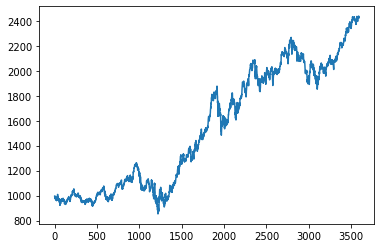

In [ ]:
episodeLogs[0].plot()

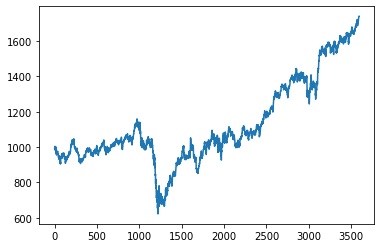

In [ ]:
episodeLogs[1].plot()

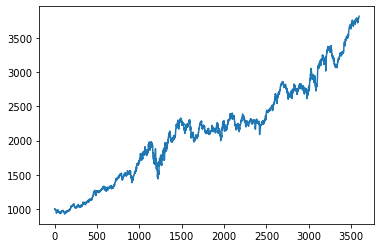

In [ ]:
episodeLogs[2].plot()

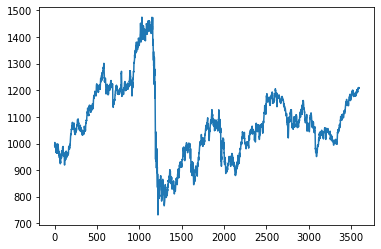

In [ ]:
episodeLogs[3].plot()

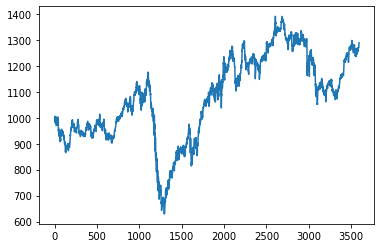

In [ ]:
episodeLogs[4].plot()

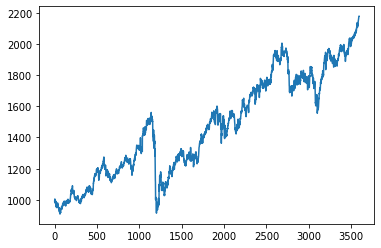

In [ ]:
episodeLogs[5].plot()

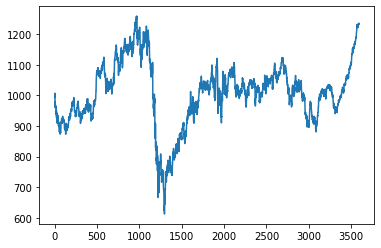

In [ ]:
episodeLogs[6].plot()

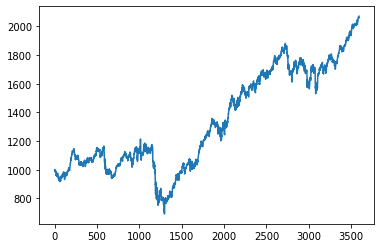

In [ ]:
episodeLogs[7].plot()

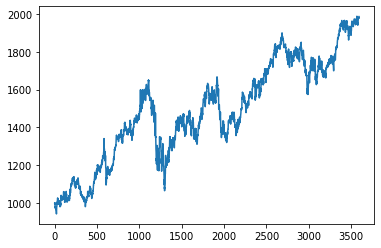

In [ ]:
episodeLogs[8].plot()

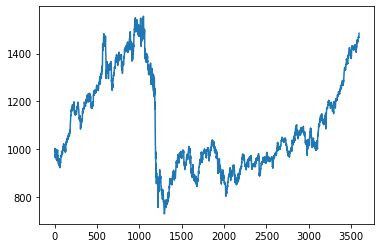

In [ ]:
episodeLogs[9].plot()